This notebook does the following:
*   Perform Doc2vec on the corpus 
*   Create an array that has all the documents in vecorized form (from doc2vec)
*   kmeans clustering on this array (12 topics identified as the best from elbow curve)
*   Make a spreadsheet that has the kmeans clusters and corresponding LDA topics ---> these spreadsheets are in the folder "Journal_Analysis/best_model/No_Essays/kmeans"





In [ ]:
pip install --upgrade gensim

     |████████████████████████████████| 23.9MB 123kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Restart Kernel

In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk import word_tokenize
import re
import seaborn as sns
import matplotlib.pyplot as plt
import smart_open
#from gensim.models import LdaModel
#from gensim.models import CoherenceModel
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
#pyLDAvis.enable_notebook()
import spacy


In [ ]:
import gensim
gensim.__version__

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


'4.0.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Journal_Analysis/"

In [ ]:
def extract_documents(folder_name):
  import os
  docs = []
  allfiles = []
  for entry in os.scandir(folder_name):
      if entry.path.endswith(".txt") and entry.is_file():
          path_paper = entry.path
          allfiles.append(path_paper)
          if os.stat(path_paper).st_size == 0:
              continue
          with open(path_paper) as f:
            text = f.read()
            docs.append(text)
  return docs, allfiles

In [ ]:
docs, allfiles = extract_documents(path + 'allpapers_NoEssays')

In [ ]:
range(len(docs))

range(0, 220)

**Vecorizing the documents using DOC2VEC**

In [ ]:
def read_corpus(docs, allfiles):
  for i in range(len(docs)):
    tokens = gensim.utils.simple_preprocess(docs[i])
    all_filenames = [file.split("/")[-1].strip('.txt') for file in allfiles]
    # For training data, add tags
    yield gensim.models.doc2vec.TaggedDocument(tokens, [all_filenames[i]])


In [ ]:
corpus = list(read_corpus(docs, allfiles))

**Training the Model (doc2vec)**

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

In [ ]:
model.build_vocab(corpus)

In [ ]:
print(f"Word 'career' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.")

Word 'career' appeared 68 times in the training corpus.


In [ ]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
def get_array(model):
  array_vectors = []
  for doc_id in range(len(corpus)):
    inferred_vector = model.infer_vector(corpus[doc_id].words)
    array_vectors.append(inferred_vector)
  return array_vectors


In [ ]:
lst = get_array(model)

In [ ]:
arr = np.array(lst)  # arr is the array containing 220 vectors representing the documents in the corpus

Trying out scikit learn **DBSCAN**  

https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98

DBSCAN has an option of choosing the distance metric. Cosine similarity works best for the document vectors obtained from doc2vec

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(metric='cosine', eps=0.5, min_samples=5).fit(arr)

In [ ]:
clustering.labels_

array([ 3,  0, -1,  3,  0, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1,  1, -1,  0,  2, -1, -1, -1, -1, -1, -1, -1,  5,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  3, -1, -1,  0,  0,
       -1,  3,  2, -1,  3, -1,  0,  4, -1,  0,  0, -1, -1, -1, -1,  5, -1,
        0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  5,  0, -1,  5,  5, -1,
       -1, -1, -1, -1, -1, -1, -1,  2, -1,  4, -1, -1, -1, -1, -1,  3, -1,
        5, -1, -1,  6, -1, -1, -1, -1, -1,  0,  3,  0, -1, -1, -1, -1,  4,
        6,  0, -1, -1,  4,  0,  1,  1, -1,  3, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  4, -1,  0,  1, -1, -1,  0,  4,  5,
       -1,  1, -1,  5, -1, -1, -1, -1,  3, -1, -1,  0, -1, -1,  0,  3,  5,
       -1, -1, -1,  5,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1,
       -1,  0,  1,  5, -1,  3, -1,  2, -1,  0,  0, -1, -1, -1,  0,  6, -1,
       -1, -1,  2, -1, -1,  6, -1, -1, -1, -1, -1,  6,  1, -1,  0, -1])

**K-Means Clustering**

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
km = KMeans(n_clusters= 10, init='k-means++', max_iter=100, n_init=1, random_state= 42)

In [ ]:
clusters = km.fit(arr)

In [ ]:
clusters.labels_

array([2, 7, 5, 2, 7, 4, 9, 5, 8, 1, 9, 9, 9, 2, 2, 1, 2, 5, 9, 7, 1, 9,
       2, 2, 9, 5, 4, 3, 5, 8, 9, 6, 8, 9, 9, 4, 9, 8, 4, 4, 6, 4, 9, 4,
       7, 7, 2, 4, 1, 7, 9, 5, 2, 2, 8, 6, 9, 7, 5, 8, 7, 7, 2, 3, 9, 9,
       9, 2, 6, 6, 8, 8, 5, 3, 1, 5, 1, 2, 2, 9, 8, 3, 9, 9, 4, 4, 7, 9,
       3, 7, 9, 4, 2, 7, 6, 5, 3, 6, 4, 4, 2, 2, 9, 6, 3, 8, 9, 3, 2, 3,
       6, 7, 2, 7, 3, 3, 2, 8, 1, 8, 7, 9, 4, 5, 7, 1, 1, 2, 2, 2, 8, 8,
       8, 1, 2, 4, 2, 2, 1, 5, 1, 9, 8, 7, 5, 9, 6, 1, 8, 8, 7, 6, 9, 5,
       1, 2, 9, 1, 5, 8, 7, 2, 8, 6, 7, 9, 6, 7, 1, 9, 8, 2, 6, 4, 2, 4,
       5, 8, 2, 8, 6, 6, 9, 6, 6, 1, 4, 2, 6, 1, 9, 9, 6, 5, 8, 6, 7, 7,
       3, 4, 3, 7, 8, 9, 1, 6, 5, 1, 5, 8, 9, 1, 3, 7, 8, 8, 1, 6, 7, 0],
      dtype=int32)

**Plotting Elbow Curve**: to identify the best k (number of clusters)

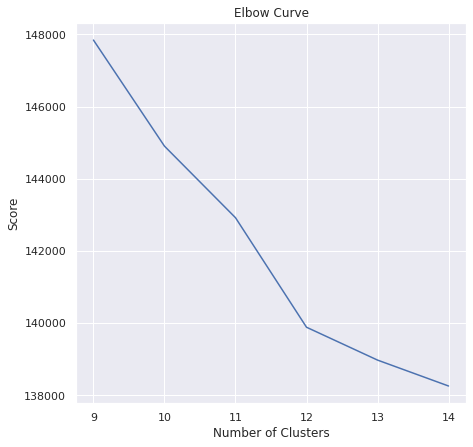

Plotting the Elbow curve took:0.5s 


In [ ]:
sns.set(rc= {'figure.figsize': (7,7)})
number_of_clusters = range(9,15)

import time
t0= time.time()
kmeans = [KMeans(n_clusters=i,max_iter=1000,random_state= 42,n_jobs=-1) for i in number_of_clusters]
score = [-1*kmeans[i].fit(arr).score(arr) for i in range(len(kmeans))]
t1= time.time()

plt.plot((number_of_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

Clustering with k=12

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
km = KMeans(n_clusters= 12, init='k-means++', max_iter=100, n_init=1, random_state= 42)

In [ ]:
clusters = km.fit(arr)

In [ ]:
clusters.labels_

array([ 2,  7,  5,  2,  7,  4,  2,  5,  8,  1,  9,  9,  9,  2,  2,  1,  2,
        5,  9,  7, 10,  9,  1,  2, 11, 10,  4,  3,  5,  8,  9,  6,  8,  9,
       11,  4,  9, 10,  4,  4,  3,  4,  9,  4,  7,  7,  2,  4,  1,  7, 11,
        5,  2, 10,  5,  6,  9, 11,  6,  5,  7,  7,  2,  3, 11,  9,  9,  2,
       11,  6, 10, 11,  5,  3,  1,  5, 10, 10, 10,  9, 11,  3,  9,  9,  4,
        4,  7,  5,  3, 11,  9,  4, 10,  7,  6,  5,  3,  3,  4,  4,  2,  2,
        9,  6,  3,  8,  9,  3,  2,  3, 10,  7,  2, 11,  3, 10,  2,  8,  1,
        5,  7,  9,  4,  5,  7,  1,  1,  2,  2,  2, 10,  8,  8,  1,  2,  4,
        2,  2,  1,  5,  1,  9,  8,  7,  5,  9, 11,  1, 11,  5, 11,  6,  9,
        5,  1,  2,  9,  1,  5, 10,  5,  2, 10,  6,  7,  9, 11,  7,  1,  9,
       10,  2,  6,  4,  2,  4,  5,  8,  2, 10, 11,  6,  9,  6,  6,  2,  4,
        2, 11,  1,  9,  9,  6,  5, 10,  6,  7,  7,  3,  4,  3, 11,  8,  9,
        1,  9, 10,  1,  5,  8,  9,  1,  3, 10, 11,  8,  1,  6,  7,  0],
      dtype=int32)

In [ ]:
km_clusters = clusters.labels_

In [ ]:
#Get a list of DOIs of the documents in the corpus
def get_doi(corpus):
  doi_list = []
  for doc_id in range(len(corpus)):
    doi_list.append(corpus[doc_id].tags[0])
  return doi_list

In [ ]:
doi_list = get_doi(corpus)

In [ ]:
#Dataframe with DOI of the paper and the topic label 
df = pd.DataFrame(np.array([doi_list, km_clusters]).T,
                   columns=['new_DOI', "kmeans_cluster_label"])

In [ ]:
df[df["kmeans_cluster_label"] == "0"]

,new_DOI,kmeans_cluster_label
219,asqu.2011.56.1.095,0


**Comparing kmeans cluster labels with 12 LDA topics classified when p>0.5**

In [ ]:
topics_all = pd.read_excel(path + "best_model/No_Essays/12topics.xlsx", index_col=0 )

In [ ]:
topics_all["new_DOI"] = topics_all["DOI"].apply(lambda x: x.replace("/", "_"))

In [ ]:
merged = pd.merge(topics_all, df, how = 'inner', on = "new_DOI")

In [ ]:
merged[merged["kmeans_cluster_label"] == '0']

,DOI,best_topic,Article-title,Year,Abstract,Authors,Total Citations,new_DOI,kmeans_cluster_label
219,asqu.2011.56.1.095,0,"Founding Conditions, Learning, and Organizatio...",2011,Empirical evidence about the relation between ...,"Gaël Le Mens, Michael T. Hannan, László Pólos",NaN,asqu.2011.56.1.095,0


In [ ]:
grouped = merged.groupby("kmeans_cluster_label").agg({
    'best_topic' : 'value_counts'})


In [ ]:
grouped.rename(columns = {"best_topic" : "Number of papers"}, inplace = True)

In [ ]:
grouped.reset_index(inplace = True)

In [ ]:
grouped.head()

,kmeans_cluster_label,best_topic,Number of papers
0,0,0,1
1,1,11,7
2,1,No right fit,5
3,1,4,2
4,1,6,2


In [ ]:
def get_percentages(group):
  percentage = (group["Number of papers"]/ group["Number of papers"].sum())*100
  return percentage 

In [ ]:
regrouped = grouped.groupby("kmeans_cluster_label").apply(get_percentages)

In [ ]:
regrouped_df = regrouped.reset_index().drop("level_1", axis=1).rename(columns = {"Number of papers" : "Percentage of LDA topic"})


In [ ]:
regrouped_df.drop("kmeans_cluster_label", axis = 1, inplace= True)

In [ ]:
# kmeans_and_lda has both LDA topic wise number of papers and percentage of each topic 
kmeans_and_lda = pd.concat([grouped, regrouped_df], axis = 1, join = "inner")

In [ ]:
kmeans_and_lda.rename(columns = {"best_topic" : "LDA_best_topic"}, inplace = True)

In [ ]:
# Joining Topic Keywords to the spreadsheet
keywords = pd.read_excel(path + "best_model/No_Essays/topics_fullcorpus_12_auto_auto.xlsx", sheet_name = "topics_wise_keywords", header = [0,1], index_col = 0)

In [ ]:
with pd.ExcelWriter(path + "best_model/No_Essays/kmeans/p>50_kmeans_12_topic_wise_fullcorpus_auto_auto.xlsx") as writer:  
  for topic, group in merged.groupby("kmeans_cluster_label"):
    group.to_excel(writer, sheet_name = str(topic))
  kmeans_and_lda.to_excel(writer, sheet_name = "Kmeans and LDA" )
  keywords.to_excel(writer, sheet_name = "LDA Topic Keywords")

**Comparing kmeans cluster labels with LDA topics classified when p>0.8**

In [ ]:
topics_all = pd.read_excel(path + "best_model/No_Essays/p>80_alltopics.xlsx")

In [ ]:
topics_all["new_DOI"] = topics_all["DOI"].apply(lambda x: x.replace("/", "_"))

In [ ]:
merged = pd.merge(topics_all, df, how = 'outer', on = "new_DOI")

In [ ]:
def get_percentages(group):
  val_counts = group.value_counts()
  return val_counts 

In [ ]:
merged.head()

,Unnamed: 0,DOI,best_topic,Article-title,Year,Abstract,Authors,Total Citations,new_DOI,kmeans_cluster_label
0,0,10.1177/0001839213486759,7,Specialization and Career Dynamics,2013,"In this article, we attempt to resolve the ten...","['John-Paul Ferguson', 'Sharique Hasan']",32,10.1177_0001839213486759,2
1,1,10.1177/0001839218793128,4,Dispositional Sources of Managerial Discretion...,2019,We investigate the dispositional sources of ma...,"['Abhinav Gupta', 'Sucheta Nadkarni', 'Misha M...",9,10.1177_0001839218793128,7
2,2,10.1177/0001839212437519,No right fit,Transcending Socialization,2011,A nine-year ethnography is used to show how tw...,['Alexandra Michel'],90,10.1177_0001839212437519,5
3,3,10.1177/0001839216673823,No right fit,These Unequal States: Corporate Organization a...,2017,In an analysis of data on employment in the 48...,"['J. Adam Cobb', 'Flannery G. Stevens']",17,10.1177_0001839216673823,2
4,4,10.1177/0001839213488773,No right fit,"CEO Narcissism, Audience Engagement, and Organ...",2013,We examine the responses of major pharmaceutic...,"['Wolf-Christian Gerstner', 'Andreas König', '...",127,10.1177_0001839213488773,7


In [ ]:
grouped = merged.groupby("kmeans_cluster_label").agg({
    'best_topic' : 'value_counts'})
  #  'best_topic' : get_percentages}) 

In [ ]:
grouped.head()

best_topic
kmeans_cluster_label best_topic              
1                    No right fit          15
                     5                      3
                     1                      2
                     2                      1
2                    No right fit          21

In [ ]:
grouped.rename(columns = {"best_topic" : "Number of papers"}, inplace = True)
#grouped["Percentage of topic"] = (grouped["Number of papers"]/grouped["Number of papers"].sum())*100


In [ ]:
grouped.reset_index(inplace = True)

In [ ]:
grouped.head()

,kmeans_cluster_label,best_topic,Number of papers
0,1,No right fit,15
1,1,5,3
2,1,1,2
3,1,2,1
4,2,No right fit,21


In [ ]:
def get_percentages(group):
  percentage = (group["Number of papers"]/ group["Number of papers"].sum())*100
  return percentage 

In [ ]:
regrouped = grouped.groupby("kmeans_cluster_label").apply(get_percentages)

In [ ]:
regrouped_df = regrouped.reset_index().drop("level_1", axis=1).rename(columns = {"Number of papers" : "Percentage of LDA topic"})


In [ ]:
regrouped_df.drop("kmeans_cluster_label", axis = 1, inplace= True)

In [ ]:
#kmeans_and_lda = pd.merge(grouped, regrouped, how = "inner" , on = "kmeans_cluster_label")

In [ ]:
kmeans_and_lda = pd.concat([grouped, regrouped_df], axis = 1, join = "inner")

In [ ]:
kmeans_and_lda.rename(columns = {"best_topic" : "LDA_best_topic"}, inplace = True)

In [ ]:
merged.groupby("best_topic")["kmeans_cluster_label"].nunique()

best_topic
0               4
1               2
2               4
3               2
4               1
5               3
6               1
7               1
8               1
9               1
No right fit    9
Name: kmeans_cluster_label, dtype: int64

In [ ]:
# Joining Topic Keywords to the spreadsheet
keywords = pd.read_excel(path + "best_model/No_Essays/topics_fullcorpus_10_auto_auto.xlsx", sheet_name = "topics_wise_keywords", header = [0,1], index_col = 0)

In [ ]:
with pd.ExcelWriter(path + "best_model/No_Essays/kmeans/p>80_kmeans_topic_wise_fullcorpus_auto_auto.xlsx") as writer:  
  for topic, group in merged.groupby("kmeans_cluster_label"):
    group.to_excel(writer, sheet_name = str(topic))
  kmeans_and_lda.to_excel(writer, sheet_name = "Kmeans and LDA")
  keywords.to_excel(writer, sheet_name = "LDA Topic Keywords")

In [ ]:
keywords.head()

topic 0                   ...       topic 9              
  Probabilities            Words  ... Probabilities         Words
0         0.008       "venture"   ...         0.021    "routine" 
1         0.007    "investment"   ...         0.018  "community" 
2         0.007      "investor"   ...         0.011   "provider" 
3         0.006          "bank"   ...         0.010  "commander" 
4         0.005  "entrepreneur"   ...         0.008  "brokerage" 

[5 rows x 20 columns]

In [ ]:
with pd.ExcelWriter(path + "best_model/No_Essays/kmeans/p>80topic_wise_fullcorpus_auto_auto.xlsx") as writer:  
  keywords.to_excel(writer, sheet_name = "LDA Topic Keywords")

**Comparing kmeans cluster labels with LDA topics classified when p>0.5**

In [ ]:
topics_all = pd.read_excel(path + "best_model/No_Essays/p>80_alltopics.xlsx") #make a new spreadsheet for p>50 

In [ ]:
topics_all["new_DOI"] = topics_all["DOI"].apply(lambda x: x.replace("/", "_"))

In [ ]:
merged = pd.merge(topics_all, df, how = 'inner', on = "new_DOI")

In [ ]:
merged.groupby("best_topic")["kmeans_cluster_label"].nunique()

best_topic
0                5
1                4
2                4
3                2
4                1
5                3
6                1
7                1
8                2
9                1
No right fit    10
Name: kmeans_cluster_label, dtype: int64

In [ ]:
with pd.ExcelWriter(path + "best_model/No_Essays/kmeans/topic_wise_fullcorpus_auto_auto.xlsx") as writer:  
  for topic, group in merged.groupby("kmeans_cluster_label"):
    group.to_excel(writer, sheet_name = str(topic))

**Assessing the model**

In [ ]:
ranks = []
second_ranks = []

#similar_docs 
for doc_id in range(len(corpus)):
    inferred_vector = model.infer_vector(corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(all_filenames[doc_id])
    ranks.append(rank)

    second_ranks.append(sims[1])


In [ ]:
inferred_vector.shape

(50,)

In [ ]:
j = 0
for i in second_ranks:
  if i[1] < 0.5:
    print("{}'s similar document: less than 0.5".format(all_filenames[j]))
    print(i[0])
  j = j+1

10.1177_0001839212441349's similar document: less than 0.5
10.1177_0001839212461439
10.1177_0001839217704811's similar document: less than 0.5
10.1177_0001839217713748


In [ ]:
second_ranks

[('10.1177_0001839211433562', 0.7246613502502441),
 ('10.1177_0001839213486984', 0.82057785987854),
 ('10.1177_0001839214553655', 0.5529376268386841),
 ('10.1177_0001839220909101', 0.7132365107536316),
 ('10.1177_0001839211427534', 0.8676475286483765),
 ('10.1177_0001839215609083', 0.7040761113166809),
 ('10.1177_0001839214531719', 0.6986525058746338),
 ('10.1177_0001839218804527', 0.6161857843399048),
 ('10.1177_0001839212439994', 0.6351875066757202),
 ('10.1177_0001839212441928', 0.7447593212127686),
 ('10.1177_0001839220911022', 0.6250776648521423),
 ('10.1177_0001839215597269', 0.8651427030563354),
 ('10.1177_0001839217694359', 0.8870086073875427),
 ('10.1177_0001839219835867', 0.7626936435699463),
 ('10.1177_0001839216673823', 0.6316832900047302),
 ('10.1177_0001839213477098', 0.5302948951721191),
 ('10.1177_0001839215610365', 0.6679982542991638),
 ('10.1177_0001839220980015', 0.568498432636261),
 ('10.1177_0001839212465077', 0.6284801959991455),
 ('10.1177_0001839213509364', 0.89

In [ ]:
dir(corpus[doc_id])
corpus[doc_id].tags

In [ ]:
inferred_vector

NameError: ignored

In [ ]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 220})


In [ ]:
len(corpus[0][1])

1

In [ ]:
for i in range(len(corpus)):
  if corpus[i].tags == ['10.1177_0001839213500272']:
    print(i)

21


In [ ]:
# Pick a random document from the corpus and infer a vector from the model
import random
#doc_id = random.randint(0, len(corpus) - 1)
for j in range(len(corpus)):
  if corpus[j].tags == ['10.1177_0001839214532428']:
    doc_id = j 
# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(corpus[doc_id].tags, ' '.join(corpus[doc_id].words)))
sim_id = second_ranks[doc_id]         #sim_id is a list of 2 elements: DOI of the similar paper, cosine similarity vale
for i in range(len(corpus)):
  if corpus[i].tags == [sim_id[0]]:
    sim_index = i    #sim_index is the index of the document that's second-most-similar to the original document (indexed doc_id)
 
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(corpus[sim_index].words)))

Train Document (['10.1177_0001839214532428']): «on the causality and cause of returns to organizational status evidence from the grands crus classés of the médoc this paper identifies the causal symbolic effect of status on the prices organizations charge for their products exploit the classification of the châteaux of the médoc which sorted wine producers into five growth classes in as fixed hierarchical symbol of class status the classification has defied attempts at revision for more than years this means that château rank in the classification cannot be reversely affected by the quality or price of its wine which greatly facilitates the estimation of the causal effect of status to determine whether status serves as signal of quality under uncertainty or satisfies the motive of conspicuous consumption study period of time during which the uncertainty about quality has arguably declined because the internet has made wine ratings ubiquitously available identify symbolic effect of stat

In [ ]:
def get_most_similar(doi):   #Format Example: '10.1177_0001839214532428' 
  for j in range(len(corpus)):
    if corpus[j].tags == [doi]:
      doc_id = j 
  inferred_vector = model.infer_vector(corpus[doc_id].words)
  sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))  # sims is a list of size of the number of documents in the corpus. Each element is a tuple (doi, similarity value)
  second_rank = sims[1] #sims[0] is the paper itself
  return sims 



**Integration LDA Model Results**
Taking results from topic model with 10 topics and topics assigned to documents when probability > 0.8

In [ ]:
topics_all = pd.read_excel(path + "best_model/No_Essays/p>80_alltopics.xlsx")

In [ ]:
topics_all["best_topic"].value_counts()

No right fit    165
4                 9
2                 9
0                 8
5                 7
8                 5
1                 5
7                 3
3                 3
9                 1
6                 1
Name: best_topic, dtype: int64

In [ ]:
papers_topics = topics_all[topics_all["best_topic"] != "No right fit"]

In [ ]:
topic0 = papers_topics[papers_topics["best_topic"] == 0]
topic0.head()


,Unnamed: 0,DOI,best_topic,Article-title,Year,Abstract,Authors,Total Citations
21,21,10.1177/0001839213500272,0,Constrained Delegation,2013,We examine the influence of competitive spillo...,"['Metin Sengul', 'Javier Gimeno']",23
31,31,10.1177/0001839214532428,0,On the Causality and Cause of Returns to Organ...,2014,This paper identifies the causal symbolic effe...,['Daniel Malter'],34
47,47,10.1177/0001839218766310,0,Colleagues and Competitors: How Internal Socia...,2019,Intra-organizational comparisons—managers and ...,"['Oliver Baumann', 'J. P. Eggers', 'Nils Stieg...",3
82,82,10.1177/0001839216674457,0,State Ownership and Firm Innovation in China: ...,2017,Using two longitudinal panel datasets of Chine...,"['Kevin Zheng Zhou', 'Gerald Yong Gao', 'Hongx...",179
135,135,10.1177/0001839215585602,0,(Un)Tangled,2015,We explore the relationship between status and...,"['Timothy G. Pollock', 'Peggy M. Lee', 'Kyuho ...",44


In [ ]:
topic0["new DOI"] = topic0["DOI"].apply(lambda x: x.replace("/", "_"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
topic0["new DOI"].apply(get_most_similar)

21     [(10.1177_0001839213500272, 0.9952492713928223...
31     [(10.1177_0001839214532428, 0.9949886798858643...
47     [(10.1177_0001839218766310, 0.9915781617164612...
82     [(10.1177_0001839216674457, 0.9924858212471008...
135    [(10.1177_0001839215585602, 0.9954397678375244...
144    [(10.1177_0001839218793384, 0.9914360046386719...
172    [(10.1177_0001839216661150, 0.9957326054573059...
183    [(10.1177_0001839212446689, 0.9917332530021667...
Name: new DOI, dtype: object

Recursively search for the papers in "No right fit" if their most similar paper is in the papers that have been classified to one of the 10 topics. 